# Laboratorio de regresión - 4

|                |   |
:----------------|---|
| **Nombre**     |Emilio Navarro   |
| **Fecha**      |  08-02-2026 |
| **Expediente** |757955   |

## Modelos penalizados

Hasta ahora la función de costo que usamos para decidir qué tan bueno es nuestro modelo al momento de ajustar es:

$$ \text{RSS} = \sum_{i=1}^n e_i^2 = \sum_{i=1}^n (y_i - \hat{y_i})^2 $$

Dado que los errores obtenidos son una combinación de sesgo y varianza, puede ser que se sesgue un parámetro para minimizar el error. Esto significa que el modelo puede decidir que la salida no sea una combinación de los factores, sino una fuerte predilección sobre uno de los factores solamente. 

E.g. se quiere ajustar un modelo

$$ \hat{z} = \hat{\beta_0} + \hat{\beta_1} x + \hat{\beta_2} y $$

Se ajusta el modelo y se decide que la mejor decisión es $\hat{\beta_1} = 10000$ y $\hat{\beta_2}=50$. Considera limitaciones de problemas reales:
- Quizás los parámetros son ajustes de maquinaria que se deben realizar para conseguir el mejor producto posible, y que $10000$ sea imposible de asignar.
- Quizás los datos actuales están sesgados y sólo hacen parecer que uno de los factores importa más que el otro.

Una de las formas en las que se puede mitigar este problema es penalizando a los parámetros del modelo, cambiando la función de costo:

$$ \text{RSS}_{L2} = \sum_{i=1}^n e_i^2  + \lambda \sum_{j=1}^p \hat{\beta_j}^2 $$

El *L2* significa que se está agregando una penalización de segundo orden. Lo que hace esta penalización es que los factores ahora sólo tendrán permitido crecer si hay una reducción al menos proporcional en el error (sacrificamos sesgo, pero reducimos la varianza).

Asimismo, existe la penalización *L1*

$$ \text{RSS}_{L1} = \sum_{i=1}^n e_i^2  + \lambda \sum_{j=1}^p |\hat{\beta_j}| $$

A las penalizaciones *L2* y *L1* se les conoce también como Ridge y Lasso, respectivamente.

Para realizar una regresión con penalización de Ridge o de Lasso usamos el objeto `Ridge(alpha=?)` o `Lasso(alpha=?)` en lugar de `LinearRegression()` de `sklearn`.

Utiliza el dataset de publicidad (Advertising.csv) y realiza 3 regresiones múltiples:

$$ \text{sales} = \beta_0 + \beta_1 (\text{TV}) + \beta_2 (\text{radio}) + \beta_3 (\text{newspaper}) + \epsilon $$

1. Sin penalización
2. Con penalización L2
3. Con penalización L1

¿Qué puedes observar al ajustar los valores de `alpha`? 

Compara los resultados de los coeficientes utilizando valores diferentes de $\alpha$ y los $R^2$ resultantes.



In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score

df = pd.read_csv("Advertising.csv")

df = df.drop(columns=[c for c in df.columns if "Unnamed" in c], errors="ignore")

X = df[["TV", "radio", "newspaper"]]
y = df["sales"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.head(), y_train.head()


(        TV  radio  newspaper
 79   116.0    7.7       23.1
 197  177.0    9.3        6.4
 38    43.1   26.7       35.1
 24    62.3   12.6       18.3
 122  224.0    2.4       15.6,
 79     11.0
 197    12.8
 38     10.1
 24      9.7
 122    11.6
 Name: sales, dtype: float64)

In [5]:
def fit_and_report(model_name, model, X_train, y_train, X_test, y_test, feature_names):
    pipe = Pipeline([
        ("scaler", StandardScaler()),  
        ("model", model)
    ])
    pipe.fit(X_train, y_train)

    yhat_train = pipe.predict(X_train)
    yhat_test  = pipe.predict(X_test)

    r2_train = r2_score(y_train, yhat_train)
    r2_test  = r2_score(y_test, yhat_test)

    coefs = pipe.named_steps["model"].coef_
    intercept = pipe.named_steps["model"].intercept_

    row = {
        "modelo": model_name,
        "alpha": getattr(model, "alpha", np.nan),
        "R2_train": r2_train,
        "R2_test": r2_test,
        "intercept": intercept
    }
    for name, val in zip(feature_names, coefs):
        row[f"beta_{name}"] = val

    return row

feature_names = list(X.columns)

alphas = [0.001, 0.01, 0.1, 1, 10, 100]

rows = []

rows.append(fit_and_report(
    "LinearRegression (sin penalización)",
    LinearRegression(),
    X_train, y_train, X_test, y_test,
    feature_names
))

for a in alphas:
    rows.append(fit_and_report(
        "Ridge (L2)",
        Ridge(alpha=a),
        X_train, y_train, X_test, y_test,
        feature_names
    ))

for a in alphas:
    rows.append(fit_and_report(
        "Lasso (L1)",
        Lasso(alpha=a, max_iter=20000),
        X_train, y_train, X_test, y_test,
        feature_names
    ))

results = pd.DataFrame(rows)

results = results.sort_values(["modelo", "alpha"], na_position="first").reset_index(drop=True)
results


,modelo,alpha,R2_train,R2_test,intercept,beta_TV,beta_radio,beta_newspaper
0,Lasso (L1),0.001,0.895701,0.899439,14.1,3.763243,2.791649,0.055249
1,Lasso (L1),0.010,0.895692,0.899443,14.1,3.754675,2.785686,0.048727
2,Lasso (L1),0.100,0.894867,0.898336,14.1,3.669206,2.719147,0.000000
3,Lasso (L1),1.000,0.822428,0.817997,14.1,2.815212,1.865153,0.000000
4,Lasso (L1),10.000,0.000000,-0.004757,14.1,0.000000,0.000000,0.000000
5,Lasso (L1),100.000,0.000000,-0.004757,14.1,0.000000,0.000000,0.000000
6,LinearRegression (sin penalización),NaN,0.895701,0.899438,14.1,3.764196,2.792307,0.055976
7,Ridge (L2),0.001,0.895701,0.899437,14.1,3.764174,2.792288,0.055983
8,Ridge (L2),0.010,0.895701,0.899432,14.1,3.763970,2.792115,0.056051
9,Ridge (L2),0.100,0.895700,0.899377,14.1,3.761934,2.790393,0.056726


,modelo,alpha,R2_train,R2_test,beta_TV,beta_radio,beta_newspaper
0,Lasso (L1),0.001,0.895701,0.899439,3.763243,2.791649,0.055249
1,Lasso (L1),0.010,0.895692,0.899443,3.754675,2.785686,0.048727
2,Lasso (L1),0.100,0.894867,0.898336,3.669206,2.719147,0.000000
3,Lasso (L1),1.000,0.822428,0.817997,2.815212,1.865153,0.000000
4,Lasso (L1),10.000,0.000000,-0.004757,0.000000,0.000000,0.000000
5,Lasso (L1),100.000,0.000000,-0.004757,0.000000,0.000000,0.000000
6,LinearRegression (sin penalización),NaN,0.895701,0.899438,3.764196,2.792307,0.055976
7,Ridge (L2),0.001,0.895701,0.899437,3.764174,2.792288,0.055983
8,Ridge (L2),0.010,0.895701,0.899432,3.763970,2.792115,0.056051
9,Ridge (L2),0.100,0.895700,0.899377,3.761934,2.790393,0.056726


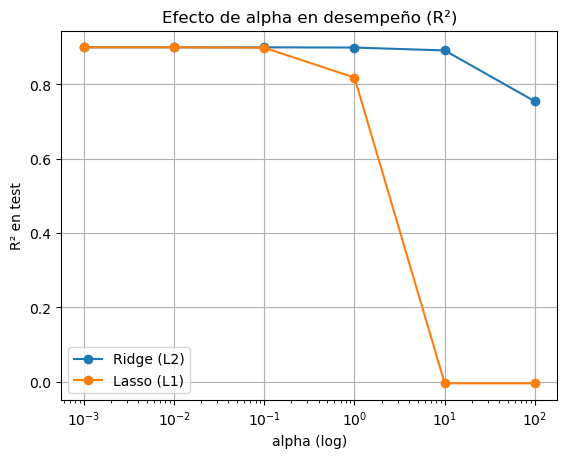

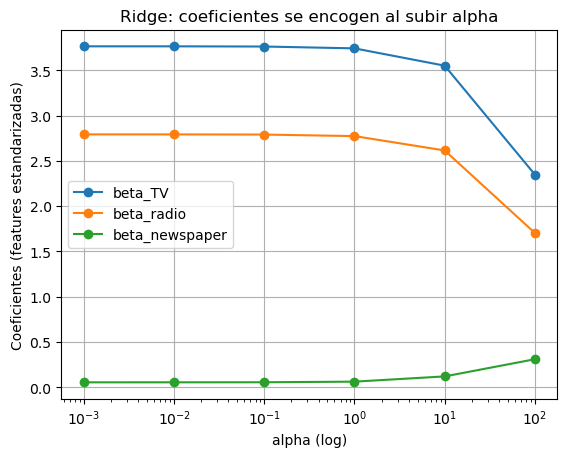

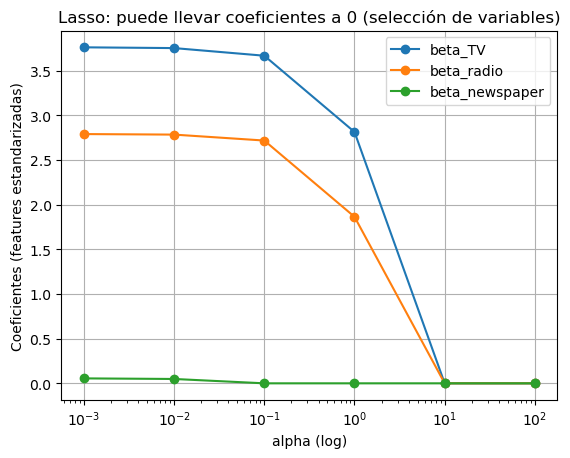

Observaciones al variar alpha:
- Al subir alpha, Ridge encoge todos los coeficientes hacia 0.
- Al subir alpha, Lasso puede hacer que algunos coeficientes queden EXACTAMENTE en 0.
- Si alpha es muy grande, ambos modelos pueden perder desempeño el r2 baja por exceso de regularización.


In [4]:
import matplotlib.pyplot as plt

cols_show = ["modelo", "alpha", "R2_train", "R2_test", "beta_TV", "beta_radio", "beta_newspaper"]
display(results[cols_show])

ridge_res = results[results["modelo"] == "Ridge (L2)"].copy()
lasso_res = results[results["modelo"] == "Lasso (L1)"].copy()

plt.figure()
plt.plot(ridge_res["alpha"], ridge_res["R2_test"], marker="o", label="Ridge (L2)")
plt.plot(lasso_res["alpha"], lasso_res["R2_test"], marker="o", label="Lasso (L1)")
plt.xscale("log")
plt.xlabel("alpha (log)")
plt.ylabel("R² en test")
plt.title("Efecto de alpha en desempeño (R²)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(ridge_res["alpha"], ridge_res["beta_TV"], marker="o", label="beta_TV")
plt.plot(ridge_res["alpha"], ridge_res["beta_radio"], marker="o", label="beta_radio")
plt.plot(ridge_res["alpha"], ridge_res["beta_newspaper"], marker="o", label="beta_newspaper")
plt.xscale("log")
plt.xlabel("alpha (log)")
plt.ylabel("Coeficientes (features estandarizadas)")
plt.title("Ridge: coeficientes se encogen al subir alpha")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(lasso_res["alpha"], lasso_res["beta_TV"], marker="o", label="beta_TV")
plt.plot(lasso_res["alpha"], lasso_res["beta_radio"], marker="o", label="beta_radio")
plt.plot(lasso_res["alpha"], lasso_res["beta_newspaper"], marker="o", label="beta_newspaper")
plt.xscale("log")
plt.xlabel("alpha (log)")
plt.ylabel("Coeficientes (features estandarizadas)")
plt.title("Lasso: puede llevar coeficientes a 0 (selección de variables)")
plt.legend()
plt.grid(True)
plt.show()

print("Observaciones al variar alpha:")
print("- Al subir alpha, Ridge encoge todos los coeficientes hacia 0.")
print("- Al subir alpha, Lasso puede hacer que algunos coeficientes queden EXACTAMENTE en 0.")
print("- Si alpha es muy grande, ambos modelos pueden perder desempeño el r2 baja por exceso de regularización.")
